# Importing libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
import warnings
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf


warnings.simplefilter(action='ignore', category=FutureWarning)
# configurations

# Reading and setting up data files

In [2]:
holidays_events = pd.read_csv(
    "/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.rename(columns={'type': 'holiday_type'})

oil = pd.read_csv(
    '/kaggle/input/store-sales-time-series-forecasting/oil.csv',
    parse_dates=['date'],
    infer_datetime_format=True,
)
oil = oil.rename(columns={'dcoilwtico': 'oil_price'})

stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
stores.cluster = stores.cluster.astype("int8")
stores = stores.rename(columns={'type': 'store_type'})

transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')

train = pd.read_csv(
    '/kaggle/input/store-sales-time-series-forecasting/train.csv',
    parse_dates=['date'],
    infer_datetime_format=True,
)

test = pd.read_csv(
    '/kaggle/input/store-sales-time-series-forecasting/test.csv',
    dtype = {
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'float32',
    }, 
    parse_dates=['date'],
    infer_datetime_format=True,
)



# !! Additional Data: Wages in public sector paid every two weeks
#                     Earthquake of magnitude 7.8 struck Ecuador on April 16,  2016



# Data Cleaning and Transforming

In [3]:
#Merging datasets
train = train.merge(stores, on = 'store_nbr')
train = train.merge(oil, on = 'date', how='left')
train["date"] = pd.to_datetime(train.date)

In [188]:
train.head()

id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  store_type  cluster  oil_price  
0          D       13        NaN  
1          D       13        NaN  
2          D       13        NaN  
3          D       13        NaN  
4          D       13        NaN

In [189]:
# Detecting missing values
train.isnull().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
city                0
state               0
store_type          0
cluster             0
oil_price      928422
dtype: int64

In [4]:
# Filling missing oil price data with linear interpolation
train['oil_price'] = train['oil_price'].interpolate(limit_direction = 'both')

# Filling the rest of missing data for holiday data (null means there is no holiday on this date)
# missingDataCols = ['holiday_type', 'locale', 'locale_name', 'description']
# train[missingDataCols] = train[missingDataCols].fillna('NA' , inplace = True) 
# train['transferred'] = train['transferred'].fillna('False')

In [191]:
# Checking again to make sure there are no null values
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
city           0
state          0
store_type     0
cluster        0
oil_price      0
dtype: int64

In [192]:
train.duplicated().any()

False

In [193]:
train.info

<bound method DataFrame.info of               id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

       

# Exploratory Data Analysis
1. What is the trend and seasonality? 
2. How are oil prices correlated to sales? Time lags?
3. How much do holidays affect the sales?
4. How does store city, state and type affect sales for that store? 
5. What time series features are there?
6. Did the earthquake affect the sales? April 16, 2016
7. Are there any outlier stores / families? (Complex trends or zero transactions due to store not selling that family)


## Trend
### Determining trend order with moving average

In [194]:
# Overall trend: Take sum of all stores and families for each day, then plot 
daily_sales = train[['date', 'sales']].copy()
daily_sales = daily_sales.groupby('date').sum().reset_index()
daily_sales.head()

date          sales
0 2013-01-01    2511.618999
1 2013-01-02  496092.417944
2 2013-01-03  361461.231124
3 2013-01-04  354459.677093
4 2013-01-05  477350.121229

In [195]:
px.line(daily_sales, x='date', y='sales', title = 'Daily Sales Over Time')

In [196]:
# Determining order of polynomial trend for daily sales
moving_average = daily_sales['sales'].rolling(
    window = len(daily_sales['sales']),
    center = True,
    min_periods = len(daily_sales['sales'])//2,
).mean()

daily_sales['moving_average'] = moving_average

In [197]:
fig1 = px.scatter(daily_sales, x='date', y='sales')
fig2 = px.line(daily_sales, x='date', y='moving_average', color_discrete_sequence=['red'])
fig3 = go.Figure(data=fig1.data + fig2.data)
fig3 = fig3.update_layout(xaxis_title="Sales", yaxis_title="Date", title = 'Moving average over time')
fig3.show()

The overall sales trend for the training data is close to linear. However, the economy can be volatile, and a good way to predict the average sales of the 15 days after training data is to perform linear regression only on data from 2017 and beyond. 

## Seasonality
### Seasonal indicators for day of week

In [198]:
dowSales = daily_sales.copy() #day of week sales
dowSales['year'] = dowSales['date'].dt.year
dowSales['dayofweek'] = dowSales['date'].dt.dayofweek+1
dowSales = dowSales.groupby(['year','dayofweek']).sales.mean().reset_index()

In [199]:
px.line(dowSales, x='dayofweek', y='sales', color = 'year')

From the training data, we see a tendancy for the total number of sales to decrease on thursday, and it increases until it reaches a peak on sunday. However, this is for the total sales, whereas each family can have a different weekly sales trend (to be explored later on). 
### missing lin reg ?

### Fourier features for shape of seasonal curve

In [200]:
"""periodogram"""

'periodogram'

In [201]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [202]:
y = daily_sales[daily_sales.date.dt.year == 2017][['date','sales']].copy()
y['date'] = y.date.dt.to_period('D')

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.date,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

X = dp.in_sample()

In [203]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y.sales)

LinearRegression(fit_intercept=False)

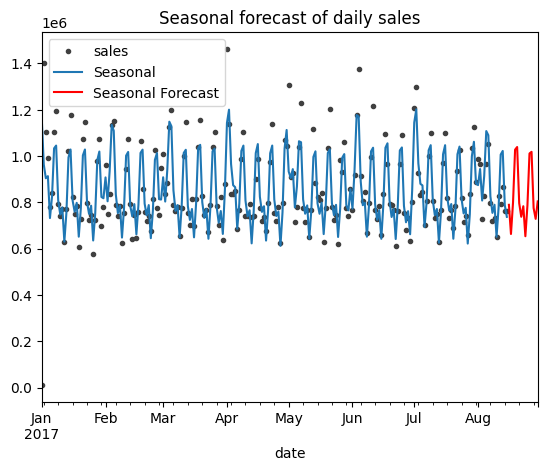

In [204]:
y_pred = pd.Series(model.predict(X), index=y.date)
X_fore = dp.out_of_sample(steps=15)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(x='date', color='0.25', style='.', title="Seasonal forecast of daily sales")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='Red')
_ = ax.legend()

### missing deseasonalized perdiogram

With the fourier feature transformation, we are able to fit the seasonal features of the data quite well. However, there are days with very high sales, and those are most likely going to be holidays. Next, we are going to improve the seasonal forecast by incorporating the holiday features. 
### Holiday features

In [205]:
holidays_events = holidays_events.set_index('date').to_period('D')
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

In [206]:
# Use Scikit-learn OneHotEncoder for processing the categorical holiday data to numerical (pandas: pd.get_dummies(holidays) works as well)
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=holidays.description.unique(),
)

# X_holidays = pd.get_dummies(holidays)

# Add the holiday one hot data to the first training data 
X2 = X.join(X_holidays, on='date').fillna(0.0)

In [207]:
model = LinearRegression().fit(X2, y.sales)

y_pred2 = pd.Series(
    model.predict(X2),
    index=X2.index,
    name = 'Fitted'

)
y_pred2 = pd.Series(model.predict(X2), index=X2.index)

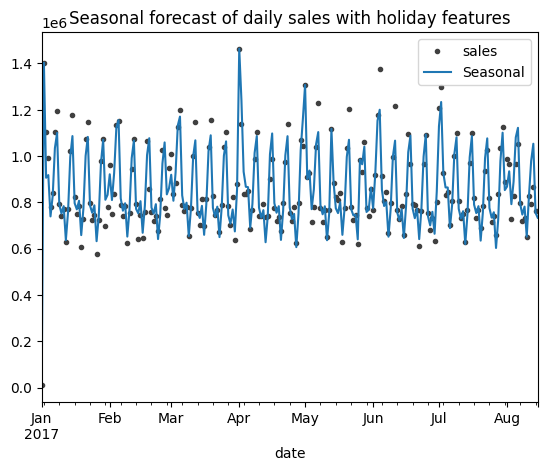

In [208]:
ax = y.plot(x='date', color='0.25', style='.', title="Seasonal forecast of daily sales with holiday features")

ax = y_pred2.plot(ax=ax, label="Seasonal")
_ = ax.legend()

The model seems to fit the data quite well with holiday features added to the fourier features, but there are concerns in overfitting the training data and the accuracy of predictions. While this model can determine when sales will increase due to holidays, it is difficult to predict how much the sales would increase (and whether past data will accurately reflect sales for the same holidays in the future). 

Possible improvement is to train a model that considers the correlation of holiday type, scale, locale, number of consecutive holidays with sales, to more accurately predict the sales for each item in each store. 

## Oil Prices
Ecuador is an oil dependent country (Oil accounts for nearly one-third of the country's GDP (The Guardian)), so oil prices might have a great effect on store sales. The fluctuation of oil prices might affect income, costs of living, consumer confidence, etc. 

My hypothesis is that oil prices would affect sales data with some time lags. This might be especially prominent on specfic goods (luxury goods) so we would be preforming regression analysis of oil prices with each product family. 

In [209]:
daily_oil = train[['date', 'oil_price']].copy()
daily_oil = daily_oil.groupby('date').mean().reset_index()
oil_and_sales = daily_sales.merge(daily_oil, on='date')
px.line(daily_oil,x='date', y='oil_price', title = 'Daily Oil Prices')

There doesn't seem to be any major correlation between oil prices and sales. However, we could test if there are any correlations with time lags applied or individual family sales with oil prices. 

In [210]:
# lagging sales data
daily_sales ['lag1']= daily_sales['sales'].shift(1)
daily_sales ['lag2']= daily_sales['sales'].shift(2)
daily_sales ['lag3']= daily_sales['sales'].shift(3)
daily_sales['lag15'] = daily_sales['sales'].shift(15)

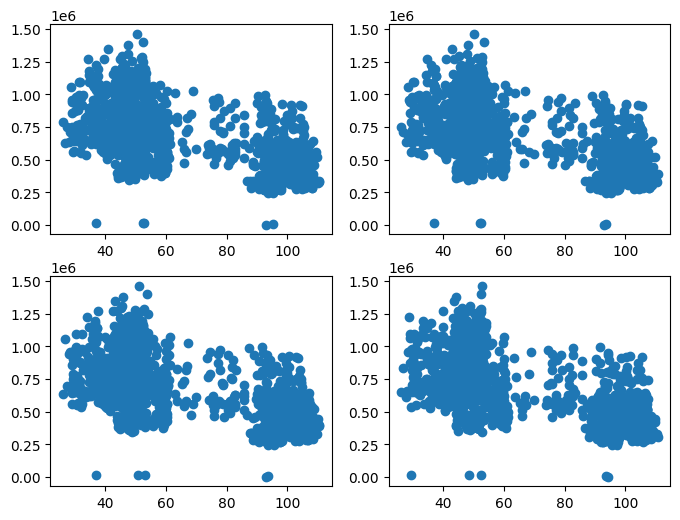

In [211]:
fig, ax = plt.subplots(2,2, figsize = (8,6))
ax[0,0].scatter(daily_oil['oil_price'], daily_sales['lag1'])
ax[0,1].scatter(daily_oil['oil_price'], daily_sales['lag2'])
ax[1,0].scatter(daily_oil['oil_price'], daily_sales['lag3'])
ax[1,1].scatter(daily_oil['oil_price'], daily_sales['lag15'])

There doesn't seem like there is any correlation between daily oil price and lagged daily sales, and there is no purpose in using lag values higher than 15.  

## Store City, State and Type

In [212]:
train['city'].unique()

array(['Quito', 'Cayambe', 'Latacunga', 'Riobamba', 'Ibarra',
       'Santo Domingo', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil',
       'Salinas', 'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad',
       'Cuenca', 'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [213]:
train['state'].unique()

array(['Pichincha', 'Cotopaxi', 'Chimborazo', 'Imbabura',
       'Santo Domingo de los Tsachilas', 'Bolivar', 'Pastaza',
       'Tungurahua', 'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja',
       'El Oro', 'Esmeraldas', 'Manabi'], dtype=object)

In [214]:
train['store_type'].unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

In [215]:
#pseudocode: groupsales (daily average) by store, by city, by type and show graph

sales_by_store = train[['date','store_nbr','city','state','store_type','sales']].copy()
sales_by_store = sales_by_store.groupby(['date','store_nbr']).sum(numeric_only = True).reset_index()
px.line(sales_by_store, x='date', y='sales', color = 'store_nbr', title = 'Daily sales by store')

There are some stores with trends quite differently from others, we can try to find the correlation between the stores.

In [216]:
sales_pivot = sales_by_store.pivot(index = 'date', columns = 'store_nbr', values = 'sales')
corr_matrix = sales_pivot.corr()
mask = np.triu(corr_matrix.corr())

Text(0.5, 1.0, 'Correlation Matrix Between Stores')

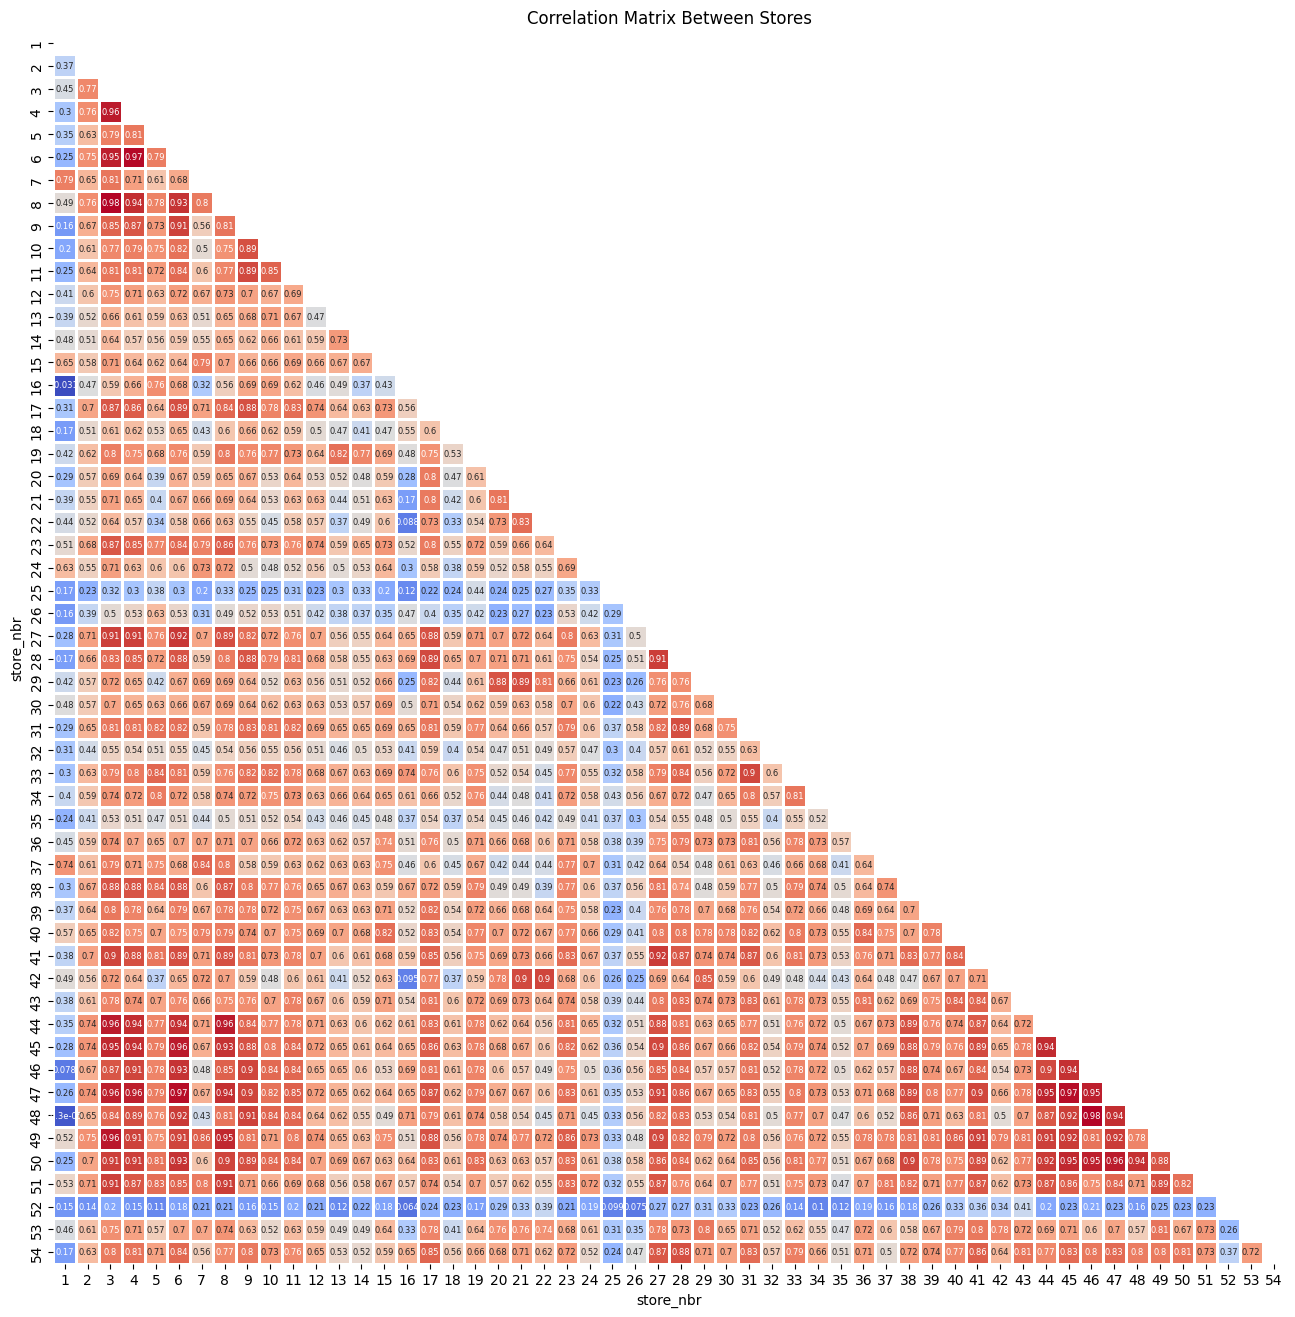

In [217]:
plt.figure(figsize=(16, 16))
sns.heatmap(corr_matrix,
            annot = True,
            cmap = 'coolwarm',
            linewidths=1,annot_kws={'size': 6},
            mask = mask,
            square = True,
            cbar =False)
plt.title('Correlation Matrix Between Stores')

From the heatmap, we could see that stores 1, 25, 26 and 52 are quite different from the others. We can examine this further by looking at store state and store type data.

In [218]:
sales_by_state = train[['state','sales']].copy()
sales_by_state = sales_by_state.groupby(['state']).mean().reset_index()
sales_by_type = train[['store_type','sales']].copy()
sales_by_type = sales_by_type.groupby(['store_type']).mean().reset_index()

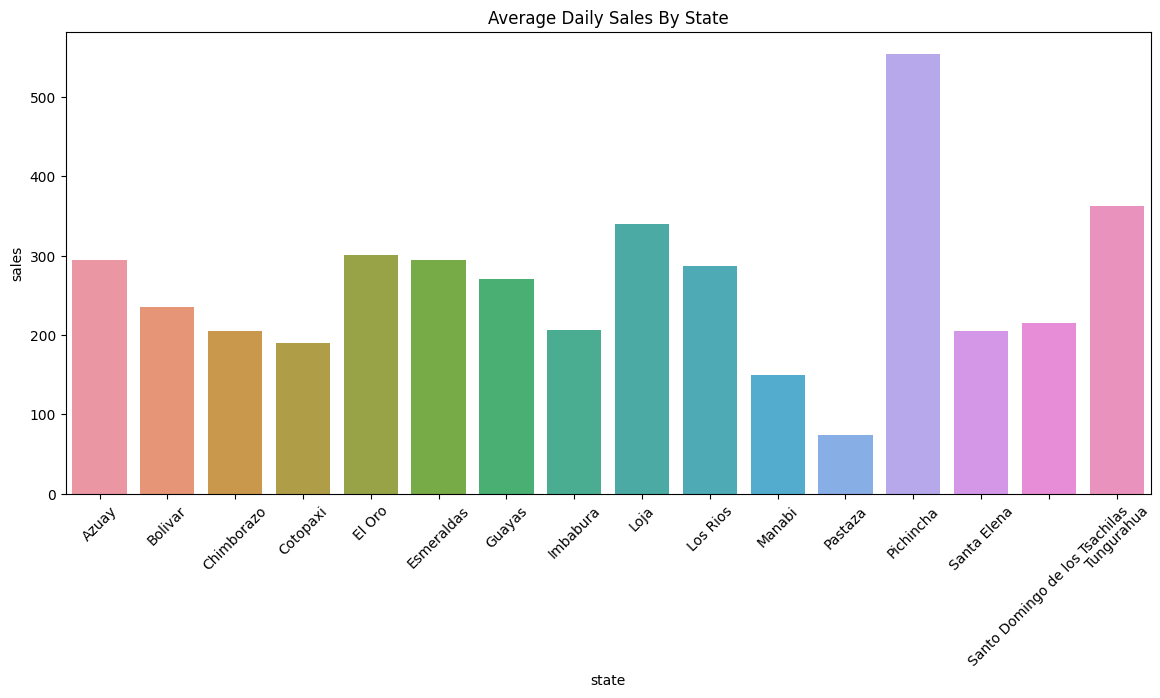

In [219]:
#px.bar(sales_by_state, x='state', y='sales', title = )
plt.figure(figsize=(14, 6))
sns.barplot(data=sales_by_state, x='state', y='sales')
plt.title('Average Daily Sales By State')
plt.xticks(rotation=45, fontsize=10)
plt.show()

Text(0.5, 1.0, 'Sales Sistribution by Store Type')

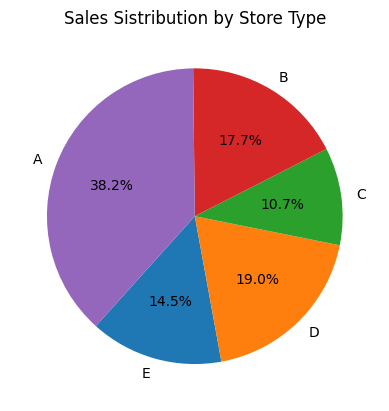

In [220]:
sales_by_type = sales_by_type.sort_values(by = 'store_type', ascending = False)
plt.pie(sales_by_type['sales'], labels = sales_by_type['store_type'], autopct='%1.1f%%', startangle=228)
plt.title('Sales Sistribution by Store Type')

## Outlier stores and families (Zero Forecasting) 
There are stores that don't sell certain familes, so we can set those values to 0 in the training data

In [221]:
zero_sales = train[['store_nbr','family','sales']].copy()
zero_sales = zero_sales.groupby(['store_nbr','family']).sum().reset_index()
zero_sales = zero_sales[zero_sales['sales'] == 0]
zero_sales.head() # this dataframe contains all the families with 0 sales in each store (will continue to be 0 in the test data)

store_nbr     family  sales
1            1  BABY CARE    0.0
268          9      BOOKS    0.0
301         10      BOOKS    0.0
334         11      BOOKS    0.0
367         12      BOOKS    0.0

## Promotions

In [222]:
pearson_corr = train['onpromotion'].corr(train['sales'], method='pearson')
print(pearson_corr)

0.4279232048121313


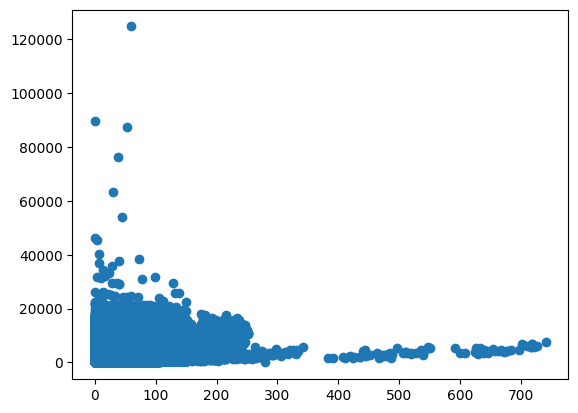

In [223]:
plt.scatter(train['onpromotion'], train['sales'])

Promotion is found to have a moderate positive correlation with sales, so it should be considered when training the predicting model. 

## Earthquake

## Time Features

# ACF and PACF
Using autocorrelation plots to find strong lag values  

In [ ]:

sales = daily_sales['sales']
autocorr = sales.autocorr()
print('Autocorrelation value is: ', autocorr)

<function matplotlib.pyplot.show(close=None, block=None)>

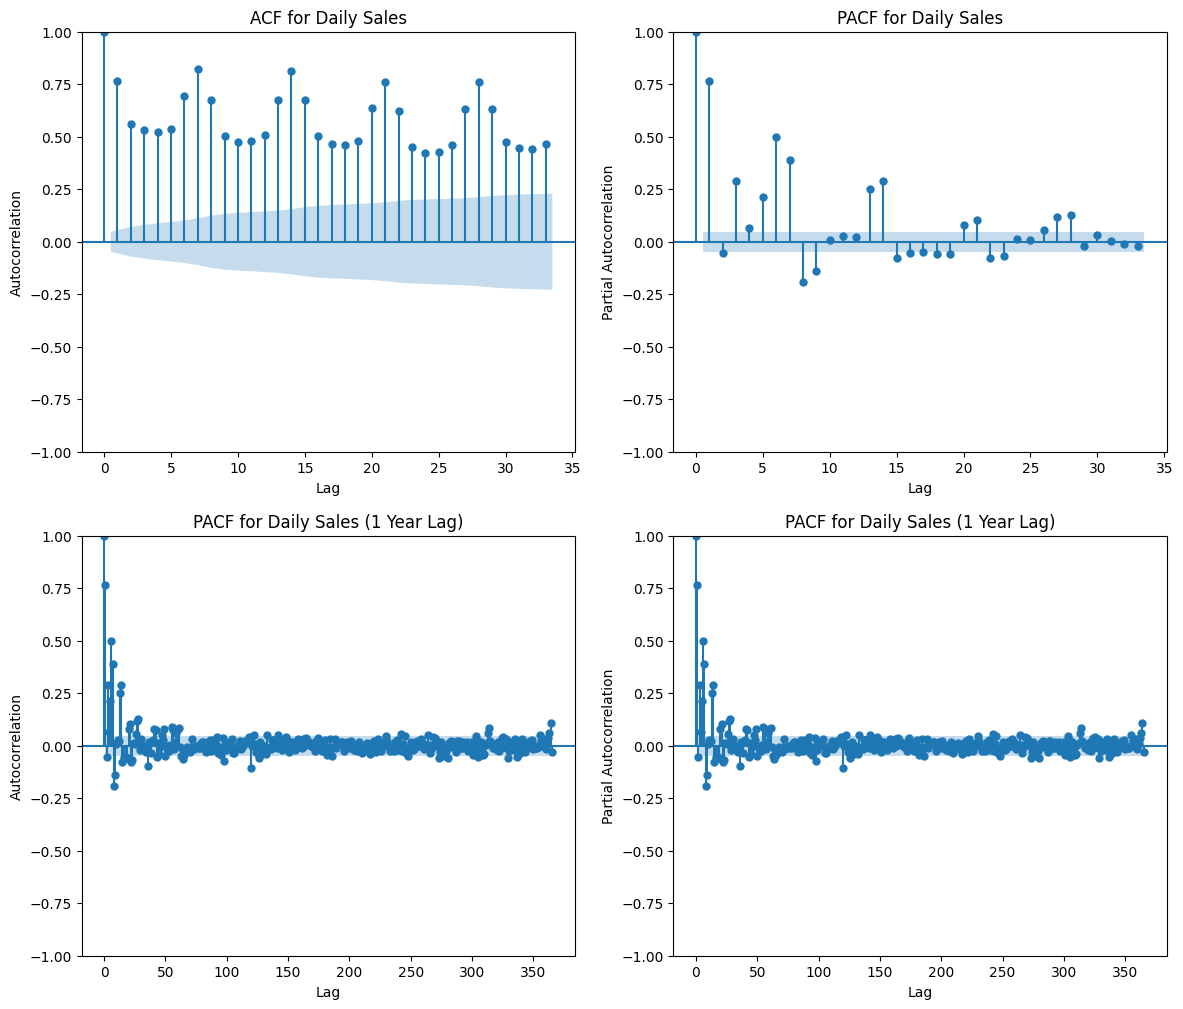

In [225]:
fig, ax = plt.subplots(2,2, figsize = (14,12))
plot_acf(daily_sales['sales'], ax=ax[0,0], title = 'ACF for Daily Sales')
ax[0,0].set_xlabel('Lag')
ax[0,0].set_ylabel('Autocorrelation')

plot_pacf(daily_sales['sales'], ax=ax[0,1], title = 'PACF for Daily Sales')
ax[0,1].set_xlabel('Lag')
ax[0,1].set_ylabel('Partial Autocorrelation')


plot_pacf(daily_sales['sales'], ax=ax[1,0], lags = 365, title = 'PACF for Daily Sales (1 Year Lag)')
ax[1,0].set_xlabel('Lag')
ax[1,0].set_ylabel('Autocorrelation')


plot_pacf(daily_sales['sales'], ax=ax[1,1], lags = 365, title = 'PACF for Daily Sales (1 Year Lag)')
ax[1,1].set_xlabel('Lag')
ax[1,1].set_ylabel('Partial Autocorrelation')


plt.show

In [226]:
family_sales = train[['date','family','sales']].copy()
family_sales = family_sales.groupby(['date','family']).sum(numeric_only=True).reset_index().copy()
family_sales = family_sales.pivot(index = 'date', columns = 'family', values = 'sales')
family_sales.head()

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2013-01-01         0.0        0.0     2.0      810.0    0.0     180.58900   
2013-01-02       255.0        0.0   207.0    72092.0    0.0   26246.31900   
2013-01-03       161.0        0.0   125.0    52105.0    0.0   18456.48002   
2013-01-04       169.0        0.0   133.0    54167.0    0.0   16721.96901   
2013-01-05       342.0        0.0   191.0    77818.0    0.0   22367.76108   

family      CELEBRATION  CLEANING    DAIRY         DELI  ...  MAGAZINES  \
date                                                     ...              
2013-01-01          0.0     186.0    143.0     71.09000  ...        0.0   
2013-01-02          0.0   74629.0  23381.0  15754.50000  ...        0.0   
2013-01-03          0.0   55893.0  18001.0  11172.45500  ...        0.0   
2013-01-04          0.0   52064.0  18148.0  10143.20900  ...        0.0   
2013-01-05          0.0   70128.0  23082.0  13734.94501  ...        0.0   

family             MEATS  PERSONAL CARE  PET SUPPLIES  \
date                                                    
2013-01-01    110.801000           25.0           0.0   
2013-01-02  20871.464028        17204.0           0.0   
2013-01-03  16597.398113        12568.0           0.0   
2013-01-04  21625.963055        11303.0           0.0   
2013-01-05  20879.091050        16819.0           0.0   

family      PLAYERS AND ELECTRONICS       POULTRY  PREPARED FOODS  PRODUCE  \
date                                                                         
2013-01-01                      0.0     42.637000       37.847000      0.0   
2013-01-02                      0.0  13975.884938     5338.111976      0.0   
2013-01-03                      0.0  10674.393983     3591.388005      0.0   
2013-01-04                      0.0  10772.515038     4472.965990      0.0   
2013-01-05                      0.0  13475.009055     5830.073020      0.0   

family      SCHOOL AND OFFICE SUPPLIES      SEAFOOD  
date                                                 
2013-01-01                         0.0     0.000000  
2013-01-02                         0.0  1526.750002  
2013-01-03                         0.0  1094.310994  
2013-01-04                         0.0  1293.120995  
2013-01-05                         0.0  1245.637004  

[5 rows x 33 columns]

In [227]:
"""for family in train['family'].unique():
    fig, ax = fig, ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(family_sales[family], ax=ax[0], lags = 365, title = 'ACF for '+ family)
    ax[0].set_xlabel('Lag')
    ax[0].set_ylabel('Autocorrelation')

    plot_pacf(family_sales[family], ax=ax[1], lags = 365, title = 'PACF for '+ family)
    ax[1].set_xlabel('Lag')
    ax[1].set_ylabel('Partial Autocorrelation')"""

"for family in train['family'].unique():\n    fig, ax = fig, ax = plt.subplots(1,2, figsize = (15,5))\n    plot_acf(family_sales[family], ax=ax[0], lags = 365, title = 'ACF for '+ family)\n    ax[0].set_xlabel('Lag')\n    ax[0].set_ylabel('Autocorrelation')\n\n    plot_pacf(family_sales[family], ax=ax[1], lags = 365, title = 'PACF for '+ family)\n    ax[1].set_xlabel('Lag')\n    ax[1].set_ylabel('Partial Autocorrelation')"

Since we are predicting store sales 15 days from now, we should choose time lag values 15 or above for the moving average model. It seems like a good choice to choose lag values 16, 30, 182, 365, 730. 

# ARIMA Model
## Differencing
What to do? we got index date, family and shops 
Can we do a family * shops number of predictions: so you got family 1 * shop 1 trend (arima), then family 2 * shop 1 ... 


In [8]:
diff_sales = train[['date','store_nbr','family','sales']].copy()
diff_sales = diff_sales.pivot(index='date', columns=['store_nbr', 'family'], values='sales')
diff_sales = diff_sales.sort_index(axis=1, level=0)

In [9]:
for store_nbr, family in diff_sales.columns:
    diff_sales.loc[:, (store_nbr, family)] = diff_sales.loc[:, (store_nbr, family)] - diff_sales.loc[:, (store_nbr, family)].shift(1)
diff_sales = diff_sales.dropna()

## Stationary Test (Augmented Dickey Fuller (ADF) test)

In [10]:
from statsmodels.tsa.stattools import adfuller, kpss

In [11]:
stationary = True
for store_nbr, family in diff_sales.columns:
    ts = diff_sales[(store_nbr, family)].copy()
    if ts.std() == 0:
        continue
    adf_result = adfuller(ts)

    if adf_result[1] >= 0.05:
        stationary = False
print('Time series stationary: ', stationary)

# Kwiatkowski-Philips-Schmidt-Shin (KPSS) test
# kpss_result = kpss(ts)

Time series stationary:  True


## ACF and PACF
We can't plot ACF and PACF for each family for each store to determine the p and q value in the ARIMA model. So, we would instead use a programmatic approach to get a list of p and q values. 

In [12]:
def q_and_p (series):
    
    lag_acf = acf(series, nlags = len(series)-1)
    # Calculate q by finding the next value outside of confidence interval of 95%
    q = len(lag_acf) - 1 
    for i , x in enumerate(lag_acf): 
        if abs(x) < (1.96/ len(series) **0.5):  # Confidence threshold using normal distribution
            q = i
            break
            
    lag_pacf = pacf(series, nlags = len(series)%2-1, method='ols')
    # Calculate q by finding the next value outside of confidence interval of 95%
    p = len(lag_pacf) - 1 
    for i , x in enumerate(lag_pacf): 
        if abs(x) < (1.96/ len(series) **0.5):  # Confidence threshold using normal distribution
            p = i
            break
    return q,p

In [17]:
qp_list = []
for store_nbr, family in diff_sales.columns:
    q,p = q_and_p(diff_sales[(store_nbr, family)])
    qp_list.append((q,p))
qp_list = [(3 if x >5 else x, 3 if y > 5 else y) for x, y in qp_list] # Change all unusually big orders

## Model Training

In [18]:
from statsmodels.tsa.arima.model import ARIMA

In [19]:
diff_sales = diff_sales.T.values.astype('float32') #changes diff_sales to a numpy nadarry

In [20]:
#predictions_df = train[['date','store_nbr','family']].copy()
#predictions_df['sales'] = ''
#predictions_df = predictions_df.pivot(index=['date'], columns=['store_nbr', 'family'], values='sales')
#predictions_df = predictions_df.sort_index(axis=1, level=0)

train = train.pivot(index=['date'], columns=['store_nbr', 'family'], values='sales')
train = train.sort_index(axis=1, level=0)
last_date = train.index[-1]
new_dates = pd.date_range(start = last_date +pd.Timedelta(days = 1), periods = 16, freq = 'D')
new_rows = pd.DataFrame(index = new_dates) # I think this line is the problem (how do you make a dataframe)
train = pd.concat([train,new_rows])


## Step 2: figure out how to use the model and predict
## Step 2.5: figure out model errors
## step 3: undo diffferncing
## step 4: submition 

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
""" 
predictions_df = train.iloc[1684:]
d = 1
start = len(diff_sales[0])
end = len(train) - 2

for i, row in enumerate(diff_sales):
    q, p = qp_list[i]
    model = ARIMA (row, order = (p,d,q))
    result = model.fit()
    predictions = result.predict(start=start, end=end)
    print(i, end=' ')
    predictions_df.iloc[:,i] = predictions """

## Undo differencing

In [ ]:
predictions_df.to_csv('output.csv')

# Model Evaluation and Optimization

# Predicting and Submission

In [ ]:
"""
#### from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

average_transactions = (
    transactions
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=average_transactions.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=15)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)


ax = y.plot(color='0.25', style='.', title="Seasonal forecast of average transactions")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

"""